In [1]:
cd /tf/astromer

/tf/astromer


In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys,os
from core.data import pretraining_records, from_generator
from core.input import input_format
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import seaborn as sns, numpy as np

In [11]:
dataset = pretraining_records('./data/records/macho2/train', 128, msk_frac=0.5, rnd_frac=0.2, same_frac=0.2,
                              max_obs=20)

In [30]:
dataset = from_generator(20, 10, 16)

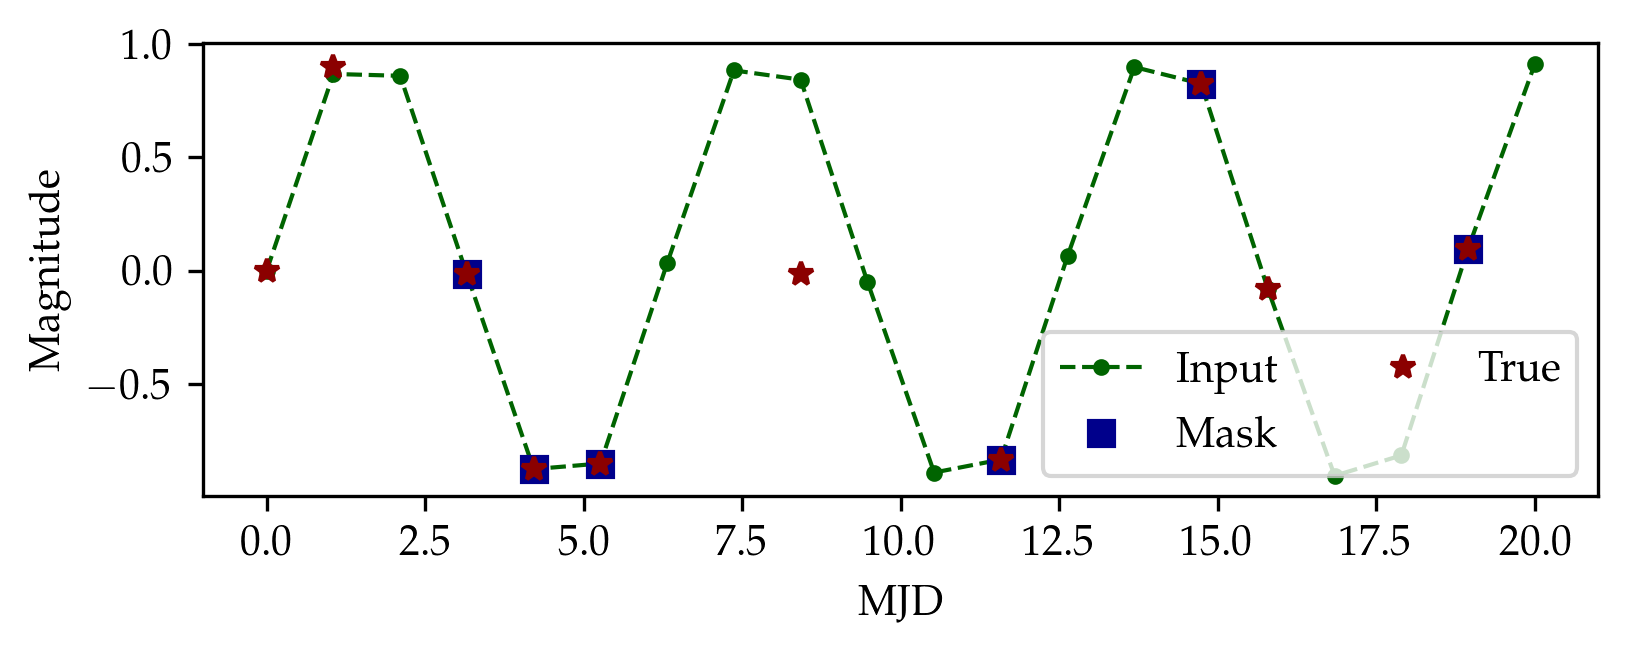

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(6,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
for batch in dataset:

    x_input  = batch['input'][-1]
    x_output = batch['output'][-1]
    t_sample = batch['times'][-1]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1])
    mask_out = tf.squeeze(batch['mask_out'][-1])
    

    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)
    

    times_masked_out = tf.boolean_mask(t_sample, mask_out)
    serie_masked_out = tf.boolean_mask(x_input, mask_out)
        
    axes.plot(t_sample, x_output, color='darkgreen', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.plot(times_masked, serie_masked, marker='s', linestyle='', color='darkblue', label='Mask', linewidth=1)
    axes.plot(times_masked_out, serie_masked_out, color='darkred', linestyle='', marker='*', label='True', linewidth=1)

    axes.set_xlabel('MJD')
    axes.set_ylabel('Magnitude')    
    axes.legend(ncol=2)#bbox_to_anchor=(0.1, 1.2), ncol=4)
    break

In [8]:
fig.savefig('./presentation/figures/input.pdf', bbox_inches='tight', format='pdf')